### Imports and data reading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, ttest_ind
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
import seaborn as sns

In [2]:
training_data = pd.read_csv("../training data.csv")
training_data.head()

,PDB codes,VDWAALS 1,EEL 1,EGB 1,ESURF 1,GGAS 1,GSOLV 1,TOTAL 1,hbdist_mean1,hbdist_std1,...,GGAS 2,GSOLV 2,TOTAL 2,hbdist_mean2,hbdist_std2,hbnum_mean2,hbnum_std2,hbnum_mean_<.35_2,hbnum_std_<.35_2,Output
0,"4hj8 , 2la5",2.857144,6.346850,15.364635,2.727722,14.530470,15.364635,-113.49,-720.46,739.96,...,20.680320,18.000000,-89.04,-3797.32,3785.39,-12.50,-3886.36,3772.90,-113.46,0
1,"1osb , 2mki",2.857144,6.319618,87.585415,4.537219,65.985015,87.585415,-563.32,-11193.39,11154.77,...,11.741259,6.296703,-85.56,-260.76,305.67,-10.57,-346.32,295.11,-51.21,1
2,"5wzj , 1je8",2.857143,5.946841,31.663337,2.959525,40.330669,31.663337,-230.34,130.79,-82.34,...,26.929071,49.412587,-309.02,-25367.65,25386.51,-44.66,-25676.67,25341.85,-334.82,0
3,"3moj , 1wwd",2.857143,6.500905,13.814186,2.719199,18.559441,13.814186,-118.26,-7867.57,7908.33,...,9.180819,9.595405,-69.90,-995.71,1011.87,-8.73,-1065.60,1003.13,-62.47,1
4,"3rn2 , 2kx5",2.857141,7.035113,16.630370,2.416485,7.082917,16.630370,-79.85,-13297.79,13326.09,...,20.099900,13.930070,-90.79,-5001.44,5006.58,-12.27,-5092.23,4994.32,-97.91,0


### Useful functions

In [3]:
def cross_val(model, x, y, cv = 5, fit_params = None):
    """
    It prints the mean of cross_val_score

    """
    from sklearn.model_selection import cross_val_score
    print(type(model))
    score = cross_val_score(model, x, y, cv = cv, n_jobs = -1, fit_params = fit_params)
    print(score)
    print("mean of cross val score:")
    print(np.mean(score))
    print()
    print()

def simple_test(model, x, y):
    """
    For a model already trained
    """

    from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
    from sklearn.metrics import confusion_matrix


    y_pred = model.predict(x)

    print("--------------results-----------------------------")
    print("accuracy\t", accuracy_score(y, y_pred))
    print("f1 score\t", f1_score(y, y_pred))
    print("precision\t", precision_score(y, y_pred))
    print("recall\t\t", recall_score(y, y_pred))
    print("confusion matrix:\n", confusion_matrix(y, y_pred))
    print()

### Scaling the data

In [4]:
scaler = MinMaxScaler()
scaled_training_data = pd.DataFrame(scaler.fit_transform(training_data.iloc[:,1:-1]))
scaled_training_data['Output'] = training_data.iloc[:,-1]
scaled_training_data.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,Output
0,0.734848,0.567790,0.138163,0.411012,0.142672,0.138163,0.846356,0.681347,0.317074,0.865515,...,0.219425,0.165335,0.892359,0.618696,0.379217,0.881016,0.623812,0.379884,0.881157,0
1,0.738889,0.550689,0.882776,0.867288,0.784851,0.882776,0.000000,0.468095,0.529590,0.000000,...,0.107861,0.044671,0.898907,0.690708,0.308213,0.909507,0.696039,0.308928,0.964703,1
2,0.680808,0.316596,0.306207,0.469462,0.464672,0.306207,0.626503,0.698681,0.300295,0.647919,...,0.297413,0.489206,0.478466,0.179476,0.819991,0.406259,0.179227,0.819946,0.584069,0
3,0.665657,0.664532,0.122178,0.408863,0.192956,0.122178,0.837382,0.535816,0.463346,0.835105,...,0.075905,0.078681,0.928371,0.675743,0.322623,0.936670,0.681364,0.323373,0.949591,1
4,0.328788,1.000000,0.151213,0.332531,0.049723,0.151213,0.909650,0.425245,0.573896,0.849572,...,0.212181,0.123373,0.889067,0.594177,0.404135,0.884411,0.599209,0.404804,0.902027,0


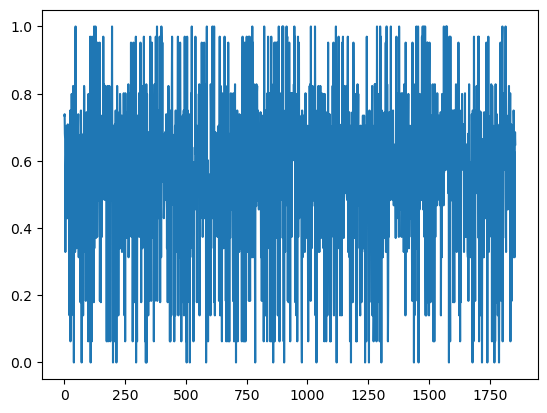

In [5]:
plt.plot(range(len(scaled_training_data)), scaled_training_data.iloc[:,0])
plt.show()

### Analysis of features

In [6]:
# Calculate p-values using ANOVA
_, p_values_anova = f_oneway(scaled_training_data.iloc[:,:-1][scaled_training_data['Output'] == 1], scaled_training_data.iloc[:,:-1][scaled_training_data['Output'] == 0])

# Calculate p-values using t-test (idea is similar to ANOVA, could also be exluded)
_, p_values_ttest = ttest_ind(scaled_training_data.iloc[:,:-1][scaled_training_data['Output'] == 1], scaled_training_data.iloc[:,:-1][scaled_training_data['Output'] == 0])

# Combine p-values (if desired)
# Using minimum p-value as a combination method
p_values_combined = np.minimum(p_values_anova, p_values_ttest)
print('p_values:', np.sort(p_values_combined))
print()

# Sort features based on p-values
sorted_features = np.argsort(p_values_combined)
print('Features in order of statistical significance:\n', training_data.columns[sorted_features+1])

p_values: [1.87379840e-20 2.74256506e-20 2.78856639e-20 2.92797218e-20
 7.58766706e-20 1.07012167e-19 1.08510365e-19 1.11830050e-19
 7.14261427e-11 8.65570640e-10 4.27424949e-08 5.95304522e-08
 3.47348395e-07 5.37653730e-07 5.71579143e-07 7.25320466e-07
 2.63081180e-05 3.32922989e-05 3.32922989e-05 9.36062854e-05
 1.47453799e-04 1.96614933e-04 3.18383556e-04 3.18383556e-04
 2.70282952e-01 4.48029726e-01]

Features in order of statistical significance:
 Index(['hbnum_std2', 'hbdist_mean2', 'hbdist_std2', 'hbnum_mean_<.35_2',
       'hbnum_std1', 'hbdist_std1', 'hbdist_mean1', 'hbnum_mean_<.35_1',
       'ESURF 2', 'ESURF 1', 'hbnum_mean2', 'hbnum_mean1', 'hbnum_std_<.35_2',
       'TOTAL 2', 'TOTAL 1', 'hbnum_std_<.35_1', 'EEL 1', 'GSOLV 2', 'EGB 2',
       'EEL 2', 'GGAS 2', 'GGAS 1', 'GSOLV 1', 'EGB 1', 'VDWAALS 1',
       'VDWAALS 2'],
      dtype='object')


### Naive Bayes

In [7]:
X_train, y_train = scaled_training_data.iloc[:,:-1], scaled_training_data.iloc[:,-1]
X_train.columns = ['VDWAALS 1', 'EEL 1', 'EGB 1', 'ESURF 1', 'GGAS 1',
       'GSOLV 1', 'TOTAL 1', 'hbdist_mean1', 'hbdist_std1', 'hbnum_mean1',
       'hbnum_std1', 'hbnum_mean_<.35_1', 'hbnum_std_<.35_1', 'VDWAALS 2',
       'EEL 2', 'EGB 2', 'ESURF 2', 'GGAS 2', 'GSOLV 2', 'TOTAL 2',
       'hbdist_mean2', 'hbdist_std2', 'hbnum_mean2', 'hbnum_std2',
       'hbnum_mean_<.35_2', 'hbnum_std_<.35_2']

In [8]:
gnb = GaussianNB()
cross_val(gnb, X_train, y_train)

<class 'sklearn.naive_bayes.GaussianNB'>
[0.62096774 0.61455526 0.60377358 0.606469   0.56334232]
mean of cross val score:
0.6018215807321103




In [9]:
cnb = ComplementNB()
cross_val(cnb, X_train, y_train)

<class 'sklearn.naive_bayes.ComplementNB'>
[0.65053763 0.606469   0.66576819 0.60916442 0.60916442]
mean of cross val score:
0.6282207344288903




### Quadratic Discriminant Analysis

In [10]:
qda = QuadraticDiscriminantAnalysis()
cross_val(qda, X_train, y_train)

<class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'>
[0.68548387 0.59838275 0.5606469  0.74932615 0.73584906]
mean of cross val score:
0.6659377445439527




In [11]:
voting = VotingClassifier([('cnb', cnb), ('qda', qda)])
cross_val(voting, X_train, y_train) 

<class 'sklearn.ensemble._voting.VotingClassifier'>
[0.65053763 0.63881402 0.68463612 0.70619946 0.66846361]
mean of cross val score:
0.6697301683911545




### Dropping features resulted non-significant

In [12]:
training_data.columns

Index(['PDB codes', 'VDWAALS 1', 'EEL 1', 'EGB 1', 'ESURF 1', 'GGAS 1',
       'GSOLV 1', 'TOTAL 1', 'hbdist_mean1', 'hbdist_std1', 'hbnum_mean1',
       'hbnum_std1', 'hbnum_mean_<.35_1', 'hbnum_std_<.35_1', 'VDWAALS 2',
       'EEL 2', 'EGB 2', 'ESURF 2', 'GGAS 2', 'GSOLV 2', 'TOTAL 2',
       'hbdist_mean2', 'hbdist_std2', 'hbnum_mean2', 'hbnum_std2',
       'hbnum_mean_<.35_2', 'hbnum_std_<.35_2', 'Output'],
      dtype='object')

In [13]:
significant_training_data = training_data[['EEL 1', 'EGB 1', 'ESURF 1', 'GGAS 1',
       'GSOLV 1', 'TOTAL 1', 'hbdist_mean1', 'hbdist_std1', 'hbnum_mean1',
       'hbnum_std1', 'hbnum_mean_<.35_1', 'hbnum_std_<.35_1',
       'EEL 2', 'EGB 2', 'ESURF 2', 'GGAS 2', 'GSOLV 2', 'TOTAL 2',
       'hbdist_mean2', 'hbdist_std2', 'hbnum_mean2', 'hbnum_std2',
       'hbnum_mean_<.35_2', 'hbnum_std_<.35_2', 'Output']]

In [14]:
significant_training_data.to_csv("ANOVAsignificant_trainingdata.csv",index=False)

In [15]:
scaled_significant_training_data = pd.DataFrame(scaler.fit_transform(significant_training_data.iloc[:,1:-1]))
scaled_significant_training_data['Output'] = significant_training_data.iloc[:,-1]
scaled_significant_training_data.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,Output
0,0.138163,0.411012,0.142672,0.138163,0.846356,0.681347,0.317074,0.865515,0.686090,0.317727,...,0.219425,0.165335,0.892359,0.618696,0.379217,0.881016,0.623812,0.379884,0.881157,0
1,0.882776,0.867288,0.784851,0.882776,0.000000,0.468095,0.529590,0.000000,0.463234,0.529020,...,0.107861,0.044671,0.898907,0.690708,0.308213,0.909507,0.696039,0.308928,0.964703,1
2,0.306207,0.469462,0.464672,0.306207,0.626503,0.698681,0.300295,0.647919,0.701074,0.300649,...,0.297413,0.489206,0.478466,0.179476,0.819991,0.406259,0.179227,0.819946,0.584069,0
3,0.122178,0.408863,0.192956,0.122178,0.837382,0.535816,0.463346,0.835105,0.540171,0.463939,...,0.075905,0.078681,0.928371,0.675743,0.322623,0.936670,0.681364,0.323373,0.949591,1
4,0.151213,0.332531,0.049723,0.151213,0.909650,0.425245,0.573896,0.849572,0.430163,0.574495,...,0.212181,0.123373,0.889067,0.594177,0.404135,0.884411,0.599209,0.404804,0.902027,0


In [16]:
s_X_train = scaled_significant_training_data.iloc[:,:-1]

In [17]:
s_gnb =  GaussianNB()
cross_val(s_gnb, s_X_train, y_train)

<class 'sklearn.naive_bayes.GaussianNB'>
[0.62365591 0.61185984 0.58760108 0.61185984 0.55256065]
mean of cross val score:
0.597507463119149




In [18]:
s_cnb =  ComplementNB()
cross_val(s_cnb, s_X_train, y_train)

<class 'sklearn.naive_bayes.ComplementNB'>
[0.64784946 0.59838275 0.65768194 0.606469   0.60916442]
mean of cross val score:
0.6239095151146277




In [19]:
s_qda =  QuadraticDiscriminantAnalysis()
cross_val(s_qda, s_X_train, y_train)

<class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'>
[0.5672043  0.52830189 0.58760108 0.58490566 0.69272237]
mean of cross val score:
0.5921470596759703




In [20]:
s_voting =  VotingClassifier([('gnb', gnb), ('cnb', cnb)])
cross_val(s_voting, s_X_train, y_train)

<class 'sklearn.ensemble._voting.VotingClassifier'>


[0.62365591 0.60107817 0.65229111 0.61455526 0.55795148]
mean of cross val score:
0.6099063849520332




### Correlation

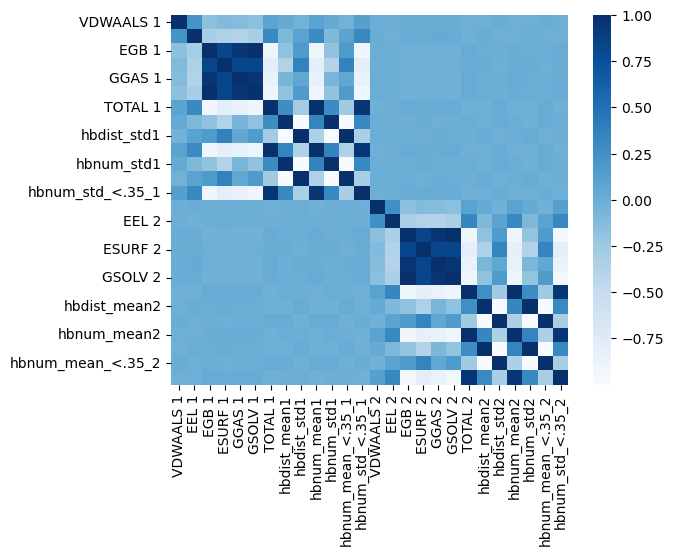

In [21]:
X_train_correlation = X_train.corr()
fig = plt.figure()
ax = sns.heatmap(X_train_correlation, annot=False, cmap = 'Blues')
plt.show()

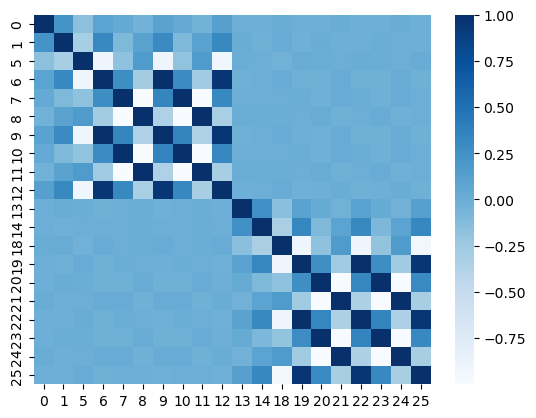

In [22]:
lesscorrelated_X_train = scaled_training_data.iloc[:, [0,1,5,6,7,8,9,10,11,12,13,14,18,19,20,21,22,23,24,25]]
lesscorrelated_X_train_correlation = lesscorrelated_X_train.corr()
fig = plt.figure()
ax = sns.heatmap(lesscorrelated_X_train_correlation, annot=False, cmap = 'Blues')
plt.show()

In [23]:
lesscorr_gnb =  GaussianNB()
cross_val(lesscorr_gnb, lesscorrelated_X_train, y_train)

<class 'sklearn.naive_bayes.GaussianNB'>
[0.59408602 0.61185984 0.606469   0.61185984 0.55256065]
mean of cross val score:
0.5953670695301858




In [24]:
lesscorr_cnb = ComplementNB()
cross_val(lesscorr_cnb, lesscorrelated_X_train, y_train)

<class 'sklearn.naive_bayes.ComplementNB'>
[0.67473118 0.64420485 0.66846361 0.64959569 0.63342318]
mean of cross val score:
0.6540837028664175




In [25]:
lesscorr_qda = QuadraticDiscriminantAnalysis()
cross_val(lesscorr_qda, lesscorrelated_X_train, y_train)

<class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'>
[0.7311828  0.73045822 0.70350404 0.73315364 0.78975741]
mean of cross val score:
0.7376112222125613




In [26]:
lesscorr_voting = VotingClassifier([('lesscorr_cnb', lesscorr_cnb), ('lesscorr_qda', lesscorr_qda)])
cross_val(lesscorr_voting, lesscorrelated_X_train, y_train)

<class 'sklearn.ensemble._voting.VotingClassifier'>


[0.66666667 0.6819407  0.72506739 0.70619946 0.69541779]
mean of cross val score:
0.695058400718778




In [27]:
print(np.sum(y_train == 1))
print(np.sum(y_train == 0))

921
935


### Testing

In [28]:
testing_data = pd.read_csv('../testing data.csv')
testing_data.describe()

,VDWAALS 1,EEL 1,EGB 1,ESURF 1,GGAS 1,GSOLV 1,TOTAL 1,hbdist_mean1,hbdist_std1,hbnum_mean1,...,GGAS 2,GSOLV 2,TOTAL 2,hbdist_mean2,hbdist_std2,hbnum_mean2,hbnum_std2,hbnum_mean_<.35_2,hbnum_std_<.35_2,Output
count,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.00000,796.000000,796.000000,796.000000,...,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000
mean,2.857143,6.260086,20.111097,2.463165,19.149511,20.111097,-140.37941,-2864.927349,2886.624899,-18.165201,...,19.256633,19.957382,-138.592965,-3214.860791,3237.783756,-17.968191,-3353.454083,3219.816018,-133.637173,0.505025
std,0.000001,0.273264,19.524547,0.863152,16.357364,19.524547,109.29323,6183.767755,6172.493108,14.360533,...,15.522056,18.229733,103.462475,6677.252010,6667.724266,13.581114,6703.991994,6663.355686,133.999346,0.500289
min,2.857140,5.442686,1.964036,1.097733,3.098901,1.964036,-563.32000,-34181.810000,-14798.970000,-72.180000,...,3.098901,1.964036,-563.320000,-34181.810000,-14798.970000,-72.180000,-34461.070000,-14846.480000,-770.010000,0.000000
25%,2.857142,6.092966,8.659341,1.871266,9.180819,8.659341,-151.75000,-3797.320000,534.320000,-20.710000,...,11.131868,11.581419,-151.750000,-4892.320000,590.080000,-20.710000,-5092.230000,578.340000,-120.120000,0.000000
50%,2.857143,6.301490,15.043956,2.297425,13.296703,15.043956,-104.98000,-864.690000,890.700000,-13.625000,...,13.850150,15.180819,-105.850000,-933.140000,955.840000,-13.800000,-1037.840000,941.330000,-96.510000,1.000000
75%,2.857144,6.438077,18.000000,2.959525,21.708292,18.000000,-75.96000,-508.760000,3832.270000,-10.570000,...,21.708292,18.000000,-79.850000,-560.920000,4673.810000,-10.790000,-658.380000,4609.710000,-66.180000,1.000000
max,2.857145,7.035113,98.955045,5.063530,83.223776,98.955045,-31.83000,14928.760000,34208.240000,-4.440000,...,83.223776,98.955045,-31.830000,14928.760000,34208.240000,-4.440000,14551.610000,34166.880000,-24.910000,1.000000


In [29]:
training_data.describe()

,VDWAALS 1,EEL 1,EGB 1,ESURF 1,GGAS 1,GSOLV 1,TOTAL 1,hbdist_mean1,hbdist_std1,hbnum_mean1,...,GGAS 2,GSOLV 2,TOTAL 2,hbdist_mean2,hbdist_std2,hbnum_mean2,hbnum_std2,hbnum_mean_<.35_2,hbnum_std_<.35_2,Output
count,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,...,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.000000,1856.00000,1856.000000,1856.000000,1856.000000
mean,2.857143,6.261621,19.845898,2.475650,19.063882,19.845898,-138.092398,-3372.093987,3394.075867,-17.953879,...,19.017939,19.911823,-138.858567,-3222.014774,3243.471099,-18.038373,-3360.87375,3225.433357,-135.439677,0.496228
std,0.000001,0.277979,18.825000,0.823388,15.764611,18.825000,107.931774,7010.515318,7001.196226,14.183721,...,16.122051,19.373996,110.374235,6819.423478,6809.466857,14.509425,6850.32790,6804.559398,144.369456,0.500121
min,2.857140,5.442686,1.964036,1.097733,3.098901,1.964036,-563.320000,-34181.810000,-14798.970000,-72.180000,...,3.098901,1.964036,-563.320000,-34181.810000,-14798.970000,-72.180000,-34461.07000,-14846.480000,-770.010000,0.000000
25%,2.857142,6.100605,11.581419,1.929098,11.131868,11.581419,-124.320000,-4892.320000,620.590000,-15.700000,...,9.180819,9.595405,-124.320000,-4248.300000,620.590000,-15.700000,-4324.52000,608.690000,-120.110000,0.000000
50%,2.857143,6.319618,15.012987,2.343994,13.378621,15.012987,-104.720000,-961.300000,981.350000,-13.625000,...,13.296703,15.012987,-104.720000,-961.300000,981.350000,-13.550000,-1050.27000,970.620000,-93.100000,0.000000
75%,2.857144,6.422024,16.995005,2.865864,20.680320,16.995005,-78.630000,-590.120000,4673.810000,-10.790000,...,20.680320,16.995005,-76.220000,-590.120000,4260.040000,-10.730000,-694.29000,4249.230000,-62.470000,1.000000
max,2.857145,7.035113,98.955045,5.063530,83.223776,98.955045,-31.830000,14928.760000,34208.240000,-4.440000,...,83.223776,98.955045,-31.830000,14928.760000,34208.240000,-4.440000,14551.61000,34166.880000,-24.910000,1.000000


In [30]:
X_test, y_test = testing_data.iloc[:,1:-1], testing_data.iloc[:,-1]

In [31]:
def remove_columns(X):
    if len(X.columns) == 26:
        return X.iloc[:, [0,1,5,6,7,8,9,10,11,12,13,14,18,19,20,21,22,23,24,25]]
    return X
remove_columns_transformer = FunctionTransformer(remove_columns)

qda_pipeline = Pipeline([
    ('remove_columns', remove_columns_transformer),
    ('scaler', MinMaxScaler()),
    ('QDA', QuadraticDiscriminantAnalysis())
])

qda_pipeline.fit(X_train, y_train)
simple_test(qda_pipeline, X_test, y_test)

--------------results-----------------------------
accuracy	 0.3731155778894472
f1 score	 0.34081902245706736
precision	 0.36338028169014086
recall		 0.3208955223880597
confusion matrix:
 [[168 226]
 [273 129]]



c:\Users\andri\anaconda3\envs\BC_ML\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [32]:
print(np.sum(y_test==1))
print(np.sum(y_test==0))

402
394
